# Deep Siamese Network 

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import mnist
from utilities import *

In [19]:
def importMNIST():
    return mnist.train_images(),np.array([mnist.train_labels()])


class DeepSiamese(object):
    def __init__(self,layers):
        self.layers = layers
        self.parameters = {
            "W1" : np.random.rand(layers[1],layers[0]) * (1/np.sqrt(layers[0])),
            "b1" : np.zeros([layers[1],1]),
            "W2" : np.random.rand(layers[3],layers[2]) * (1/np.sqrt(layers[2])),
            "b2" : np.zeros([layers[3],1])
        }
           
         
    def forward_propagation(self,X1,X2):
        self.network1_Z1 = np.dot(self.parameters["W1"],X1) + self.parameters["b1"]
        self.network1_A1 = self.activation(self.network1_Z1,mode="relu")
#         self.network1_Z2 = np.dot(self.parameters["W2"],self.A1) + self.parameters["b2"]
#         self.network1_A2 = self.activation(self.Z2,activation_function)
        
        self.network2_Z1 = np.dot(self.parameters["W1"],X2) + self.parameters["b1"]
        self.network2_A1 = self.activation(self.network2_Z1,mode="relu")
#         self.network2_Z2 = np.dot(self.parameters["W2"],self.A1) + self.parameters["b2"]
#         self.network2_A2 = self.activation(self.Z2,activation_function)
    
        self.D1 = self.L2Distance()
        
        self.Z2 = np.dot(self.parameters["W2"],self.D1) + self.parameters["b2"]
        self.A2 = self.activation(self.Z2,mode="sigmoid")
        
        
    def L2Distance(self):
        return np.abs(self.network1_A1 - self.network2_A1)
    
    
    def backward_propagation(self,X1,X2,Y):
        self.dZ2 = np.subtract(self.A2, Y)
        self.dW2 = (1/X1.shape[1]) * np.dot(self.dZ2,self.D1.T)
        
        self.dD1 = np.dot(self.parameters["W2"].T,self.dZ2)
    
        self.network1_dW1 = np.dot(self.dD1 * (self.network1_Z1 > 0),X1.T)
        self.network2_dW1 = np.dot(self.dD1 * (self.network2_Z1 > 0),X2.T)
        self.network1_db1 = self.dD1 * (self.network1_Z1 > 0)
        self.network2_db2 = self.dD1 * (self.network2_Z1 > 0)
        
        self.dW1 = (1/X1.shape[1]) * np.divide(np.add(self.network1_dW1,self.network2_dW1),2)
        self.db1 = (1/X1.shape[1]) * np.sum(np.divide(np.add(self.network1_db1,self.network2_db2),2),axis=1,keepdims=True)
        self.dW2 = (1/X1.shape[1]) * np.dot(self.dZ2,self.D1.T)
        self.db2 = (1/X1.shape[1]) * np.sum(self.dZ2,axis=1,keepdims=True)

        
    def compute_cost(self,Y):
        self.cost = (1/Y.shape[1]) * (-( np.dot(Y,np.log(self.A2).T) + np.dot(1-Y,np.log(1-self.A2).T) ))
    
    
    def update_parameters(self,beta=0.9,learning_rate=0.01):
        
        self.v["dW1"] = (self.v["dW1"] * beta) + ((1-beta) * self.dW1)
        self.v["db1"] = (self.v["db1"] * beta) + ((1-beta) * self.db1)
        self.v["dW2"] = (self.v["dW2"] * beta) + ((1-beta) * self.dW2)
        self.v["db2"] = (self.v["db2"] * beta) + ((1-beta) * self.db2)
        
        self.parameters["W1"] = self.parameters["W1"] - (learning_rate * self.v["dW1"])
        self.parameters["b1"] = self.parameters["b1"] - (learning_rate * self.v["db1"])
        self.parameters["W2"] = self.parameters["W2"] - (learning_rate * self.v["dW2"])
        self.parameters["b2"] = self.parameters["b2"] - (learning_rate * self.v["db2"])
        
    
    def grad_check(self):
        pass
    
    def train(self,trainingBatch,epochs=200,learning_rate=1e-3,beta=0.9):
        self.v = {
            "dW1":np.zeros([20,784]),
            "db1":np.zeros([20,1]),
            "dW2":np.zeros([1,20]),
            "db2":np.zeros([1,1])
        }
        m = trainingBatch[0][0].shape[1]
        self.costs = []
        for epoch in range(epochs):
            cost = 0
            for minibatch in trainingBatch:
                X1 = minibatch[0][:784,:]
                X2 = minibatch[0][784:,:]
                Y = minibatch[1]
            
                
                self.forward_propagation(X1,X2)
                self.compute_cost(Y)
                self.backward_propagation(X1,X2,Y)
                lr = np.sqrt(0.95 ** epoch) * learning_rate
                self.update_parameters(beta=beta,learning_rate=lr)
                
                cost += self.cost
            cost /= m
#             print(cost[0,0])
#             print(cost[0,1])
            self.costs.append(cost[0,0])
            if (epoch % 10 == 0):
                print("Epoch:{} \t Cost:{}".format(epoch,cost[0,0]))
        plt.plot(list(range(epochs)),self.costs)
        
    def activation(self,z,mode="relu"):
        if mode == "relu":
            return np.maximum(0,z)
        elif mode == "sigmoid":
            return 1/(1 + np.exp(-z))

In [4]:
# import data 
x_,y = importMNIST()
print(y.shape)
x_ = x_.reshape(60000,-1).T
print(x_.shape)

#normalise the input
x = normalise(x_)
 
#form the pairs
(input_pairs,labels_pairs) = get_training_pairs(x,y)

(1, 60000)
(784, 60000)


In [5]:
print(labels_pairs.shape)
print(input_pairs.shape)

(1, 27000)
(1568, 27000)


# Shuffle the dataset

In [7]:
np.random.seed(2)
permutation = np.random.permutation(input_pairs.shape[1])

shuffled_input_pairs = input_pairs[:,permutation]
shuffled_labels = labels_pairs[:,permutation]

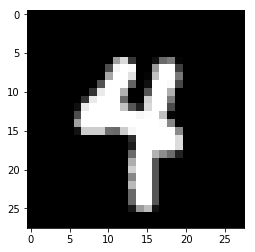

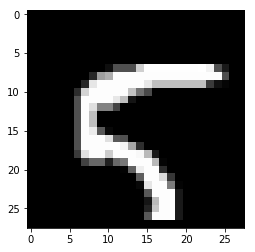

array([0.])

In [8]:
index = 99
plt.imshow(shuffled_input_pairs[:784,index].reshape(28,28),cmap='gray')
plt.show()
plt.imshow(shuffled_input_pairs[784:,index].reshape(28,28),cmap='gray')
plt.show()
shuffled_labels[:,index]

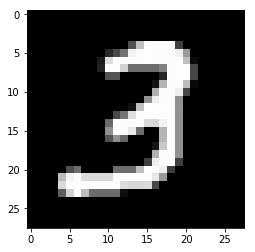

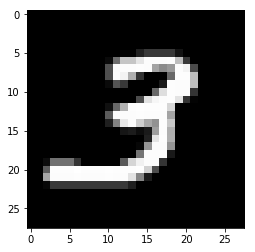

[1.]
X1 shape:(784, 128),	 X2 shape: (784, 128), 	 Y shape:(1, 128)


In [13]:
index = 127
batch = getBatch(shuffled_input_pairs,shuffled_labels)

X1 = batch[0][0][:784,index]
X2 = batch[0][0][784:,index]
Y = batch[0][1][:,index]
plt.imshow(X1.reshape(28,28),cmap='gray')
plt.show()
plt.imshow(X2.reshape(28,28),cmap='gray')
plt.show()
print(Y)
X1_ = batch[0][0][:784,:]
X2_ = batch[0][0][:784,:]
Y_ = batch[0][1]
print("X1 shape:{},\t X2 shape: {}, \t Y shape:{}".format(X1_.shape,X2_.shape,Y_.shape))

# Train the model

Epoch:0 	 Cost:1.1502029140380545
Epoch:10 	 Cost:1.132986154043409
Epoch:20 	 Cost:1.1331071915568272
Epoch:30 	 Cost:1.132895170556394
Epoch:40 	 Cost:1.1344326206053292
Epoch:50 	 Cost:1.1354483246855813
Epoch:60 	 Cost:1.1361552032890174
Epoch:70 	 Cost:1.1371614560412706
Epoch:80 	 Cost:1.1381423241242545
Epoch:90 	 Cost:1.1389136947921379
Epoch:100 	 Cost:1.1394768937706699
Epoch:110 	 Cost:1.1398846903496629
Epoch:120 	 Cost:1.1401831303528436
Epoch:130 	 Cost:1.1403974706602822
Epoch:140 	 Cost:1.140550274474189
Epoch:150 	 Cost:1.1406629999748121
Epoch:160 	 Cost:1.1407469651066315
Epoch:170 	 Cost:1.1408098714476207
Epoch:180 	 Cost:1.1408577684052115
Epoch:190 	 Cost:1.1408941167146496
Epoch:200 	 Cost:1.140921899426157
Epoch:210 	 Cost:1.1409430397143365
Epoch:220 	 Cost:1.1409591261842376
Epoch:230 	 Cost:1.140971464350561
Epoch:240 	 Cost:1.1409809444193033
Epoch:250 	 Cost:1.140988232608974
Epoch:260 	 Cost:1.1409938646048987
Epoch:270 	 Cost:1.1409982028118166
Epoch:280

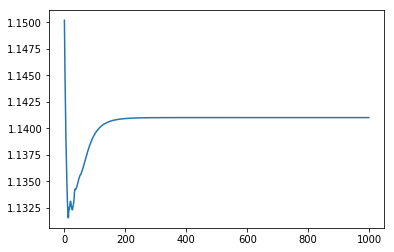

In [20]:
Siamese = DeepSiamese([X1.shape[0],20,20,1])
Siamese.train(batch,epochs=1000,learning_rate = 0.1)

# Predict training set labels

In [29]:
shuffled_input_pairs.shape
X1 = shuffled_input_pairs[:784,:]
X2 = shuffled_input_pairs[784:,:]
print(shuffled_labels.shape)
Siamese.forward_propagation(X1 = X1,X2 = X2)

(1, 27000)


In [30]:
predicted_labels = Siamese.A2 > 0.5 

In [31]:
np.mean(shuffled_labels == predicted_labels)
# np.sum(predicted_labels)

0.5152222222222222

# Import the test set

-  Import test set.
-  Normalise
-  Get the pairs.

In [33]:
x_test = mnist.test_images().reshape(10000,-1).T
y_test = mnist.test_labels().reshape(-1,10000)

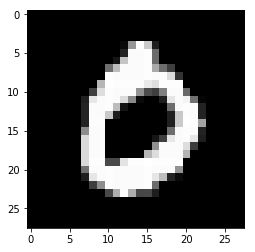

/Users/mehmetbezcioglu/miniconda3/envs/env352/lib/python3.5/site-packages/ipykernel_launcher.py:110: RuntimeWarning: overflow encountered in exp


In [36]:
(input_pairs_test,labels_pairs_test) = test_pairs(x_test,y_test)
plt.imshow(input_pairs_test[:784,0].reshape(28,28),cmap='gray')
plt.show()

Siamese.forward_propagation(X1 = input_pairs_test[:784,:],X2 = input_pairs_test[784:,:])